In [35]:
import os
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import datetime as dt
import pathlib
import pickle #to save files
from itertools import product
from scipy.stats import skew, kurtosis
from scipy.signal import butter, welch, filtfilt

from PreprocessFcns import *

%matplotlib inline

#for interactive plots
# from mpl_toolkits.mplot3d import Axes3D
# %matplotlib notebook
pd.__version__

'0.24.2'

In [36]:
# Set path to folder containing Subject data Dictionaries
path = '../Data_dict/' #dictionaries data Mac - (local, much faster)
# path = '/Volumes/RTO/CIS-PD Study/Data_dict/' #Mac
path = r'//FS2.smpp.local\\RTO\\CIS-PD Study\Data_dict' #windows repo path

#path to subject scores
pathscores = '../Scores/' #local
pathscores = r'//FS2.smpp.local\\RTO\\CIS-PD Study\Scores' #windows repo path
#---------------------------------------------------------------------------------------------------------

In [37]:
def plot_data(acts, task, trial, loc, sensor, start=0, end=None, add_noise=False, plt_ax=None):
#---------------------------------------------------------------------------------------------------------
# Plots requested data
# 
# Inputs: acts - dictionary containing all sensor data from one subject
#         task - desired activity to plot
#         trial - desired trial number to plot
#         loc - desired sensor location
#         data - desired sensor data to analyze (accel, gyro, EMG/ECG)
#         start - starting index, default starts at first point
#         end - ending index, default is 500th data point
#---------------------------------------------------------------------------------------------------------
    if sensor == 'elec':
        filterdata(acts, task, loc, trial, sensor, ftype='bandpass', cutoff_bp=[30,80])
        rawdata = acts[task][trial][loc][sensor]
        rawdata = abs(rawdata)
        rawdata = rawdata/np.mean(rawdata)
    else:
        rawdata = acts[task][trial][loc][sensor]
        
    if add_noise == True:
#         rawdata = rawdata.applymap(lambda x: x+(1/9.81)*np.random.randn(1)[0]) #additive noise
        rawdata = rawdata*(1 + 0.1*np.random.randn(1)[0]) #multiplicative noise (scaling)

    #reindex time (relative to start)
    idx = rawdata.index
    idx = idx-idx[0]
    rawdata.index = idx
    if end == None:
        rawdata.plot(figsize=(10,12),ax=plt_ax)
    else:
        rawdata.loc[(rawdata.index <= end) & (rawdata.index >= start)].plot(figsize=(14,10),ax=plt_ax)


In [38]:
#list subjects in db
d = os.listdir(path)
f = [filename[:4] for filename in d if filename.startswith('1')]
print(np.sort(f))

['1004' '1016' '1018' '1019' '1020' '1024' '1029' '1030' '1032' '1038'
 '1044' '1046' '1047' '1049' '1051' '1052' '1053' '1054' '1055' '1056']


In [39]:
#sanity check
# name = [x for x in mot_scores.columns if 'finger' in x]
# name

In [40]:
#load subject scores
mot_scores = pd.read_excel(os.path.join(pathscores, 'MotorTasks.xls'))
#fix error in original cols labels
mot_scores.columns.values[75] = 'alternating left hand movements tremor right upper limb'
#remove words:(Qxx) and 'rating' from each column for readability
cols= mot_scores.columns
# cols = cols[4:]
cols = cols.tolist()
colsnew = [x.split('(')[0] for x in cols]
colsnew = [x.strip() for x in colsnew] #remove whitspace
colsnew = [x.split('rating')[0] for x in colsnew]
colsnew = [x.strip() for x in colsnew]
colsnew = [x.lower() for x in colsnew] #make all lower case
colsnew = [x.replace('\x97',' ') for x in colsnew] #remove special char

#simplify notation
for i in range(len(colsnew)):
    x = colsnew[i]
    if x.find('finger to nose')>-1:
        colsnew[i] = x.replace(' hand','')
        
    if x.find('alternating')>-1:
        colsnew[i] = x.replace(' hand movements','')

c = dict(zip(cols,colsnew))
mot_scores = mot_scores.rename(index=str, columns=c)

In [41]:
# [x for x in mot_scores.columns if x.find('finger to nose')>-1] #simplify notation

In [42]:
mot_scores

,unnamed: 0,site,subject,visit,crf#,data collected,date of assessment,what is the participant’s state,on which hand is the subject wearing the apple watch,was the device shaken 5 times up and down prior to beginning the assessment,...,folding towels tremor left upper limb,folding towels tremor right upper limb,was sitting assessed,sitting start time,sitting end time,sitting dyskinesia left upper limb,sitting dyskinesia right upper limb,sitting tremor left upper limb,sitting tremor right upper limb,general comments
0,0,1313,1003,2 Weeks: Time 0,NaN,Yes,2017-07-03,Off,Left,Yes,...,1.0,1.0,Yes,00:22:45,00:23:15,0.0,0.0,1.0,1.0,NaN
1,1,1313,1003,2 Weeks: Time 30,NaN,Yes,2017-07-03,On,Left,Yes,...,0.0,0.0,Yes,00:19:44,00:20:14,1.0,1.0,0.0,0.0,NaN
2,2,1313,1003,2 Weeks: Time 60,NaN,Yes,2017-07-03,On,Left,Yes,...,0.0,0.0,Yes,00:19:07,00:19:37,1.0,0.0,0.0,0.0,NaN
3,3,1313,1003,2 Weeks: Time 90,NaN,Yes,2017-07-03,On,Left,Yes,...,0.0,0.0,Yes,00:23:40,00:24:10,2.0,1.0,0.0,0.0,NaN
4,4,1313,1003,2 Weeks: Time 120,NaN,Yes,2017-07-03,On,Left,Yes,...,0.0,0.0,Yes,00:14:15,00:14:45,0.0,0.0,1.0,0.0,NaN
5,5,1313,1003,2 Weeks: Time 150,NaN,Yes,2017-07-03,On,Left,Yes,...,0.0,0.0,Yes,00:17:15,00:17:45,1.0,0.0,0.0,0.0,NaN
6,6,1313,1003,4 Weeks,NaN,Yes,2017-07-24,Off,Left,Yes,...,0.0,0.0,Yes,00:14:26,00:14:56,1.0,0.0,1.0,0.0,NaN
7,7,1332,1004,2 Weeks: Time 0,NaN,Yes,2017-07-07,Off,Right,Yes,...,1.0,1.0,Yes,00:15:20,00:15:50,0.0,0.0,0.0,0.0,NaN
8,8,1332,1004,2 Weeks: Time 30,NaN,Yes,2017-07-07,Off,Right,Yes,...,0.0,0.0,Yes,00:11:53,00:12:23,0.0,0.0,0.0,0.0,NaN
9,9,1332,1004,2 Weeks: Time 60,NaN,Yes,2017-07-07,On,Right,Yes,...,0.0,0.0,Yes,00:10:10,00:10:40,0.0,1.0,0.0,0.0,NaN


In [43]:
for c in mot_scores.columns:
    print(c)

unnamed: 0
site
subject
visit
crf#
data collected
date of assessment
what is the participant’s state
on which hand is the subject wearing the apple watch
was the device shaken 5 times up and down prior to beginning the assessment
patient’s apple watch clock time when the stop watch is turned on
shaking start time
shaking end time
was standing assessed
standing start time
standing end time
standing overall score
standing dyskinesia left upper limb
standing dyskinesia right upper limb
standing tremor left upper limb
standing tremor right upper limb
was walking assessed
walking start time
walking stop time
walking overall score
walking bradykinesia left upper limb
walking bradykinesia right upper limb
walking dyskinesia left upper limb
walking dyskinesia right upper limb
walking tremor left upper limb
walking tremor right upper limb
was walking while counting assessed
walking while counting start time
walking while counting end time
walking while counting overall score
walking while count

## Choose subject, task, visit and sensor location

In [292]:
subj = 1004 #choose subj to visualize

In [293]:
#load Pickle file dict
subj_filename = str(subj) + 'dict.pkl'
f = open(os.path.join(path, subj_filename), 'rb')
act_dict = pickle.load(f)
f.close()

In [331]:
#choose task, trials(visits) and sensor location
# side = 'right' #side score to use
side = 'right' #side score to use

# task = 'Motor #8: Typing on a Computer'
# task_scores = 'typing on a computer keyboard' #the task name in the scores file

# task =  'Motor #7: Drawing on Paper'
# task_scores = 'drawing on a paper'

# task =  'Motor #5: Alternating Hand Movements'
# task_scores = 'alternating ' + side + ' hand movements'
# task_scores = 'alternating left hand movements'
# task_scores = 'alternating right hand movements'

# task = 'Motor #4: Finger to Nose'
# task_scores = 'finger to nose ' + side + ' hand'

# task = 'Motor #3: Walking while Counting'
# task_scores = 'walking while counting'

# task = 'Motor #6: Sit to Stand'
# task_scores = 'sit to stand'

# task = 'Motor #2: Walking'
# task_scores = 'walking'

# task = 'Motor #10: Drinking Water'
# task_scores = 'taking a glass of water and drinking'

task = 'Motor #11: Organizing Folder'
task_scores = 'organizing sheets in a folder'

# task = 'Motor #1: Standing'
# task_scores = 'standing'

 
trials = list(range(7))

## Scores for current subject

In [332]:
task_scores

'organizing sheets in a folder'

In [333]:
#load subject scores
mot_scores = pd.read_excel(os.path.join(pathscores, 'MotorTasks.xls'))
#remove words:(Qxx) and 'rating' from each column for readability
cols= mot_scores.columns
cols = cols[4:]
cols = cols.tolist()
colsnew = [x.split('(')[0] for x in cols]
colsnew = [x.strip() for x in colsnew] #remove whitspace
colsnew = [x.split('rating')[0] for x in colsnew]
colsnew = [x.strip() for x in colsnew]
colsnew = [x.lower() for x in colsnew] #make all lower case
colsnew = [x.replace('\x97',' ') for x in colsnew]
c = dict(zip(cols,colsnew))
mot_scores = mot_scores.rename(index=str, columns=c)

#change 1 month label to 4 wks for proper sorting
mot_scores.loc[mot_scores['visit']=='1 Month','visit']='4 Weeks'

#extract scores for corresponding task, subject and side
subj_score = mot_scores.loc[mot_scores['subject']==subj,['subject','visit',
                            task_scores+ ' ' + 'bradykinesia ' + side + ' upper limb',
                            task_scores+ ' ' + 'tremor ' + side + ' upper limb',
                            task_scores+ ' ' + 'dyskinesia ' + side + ' upper limb',                             
                            task_scores+ ' ' + 'overall score']]
#rename cols
subj_score = subj_score.rename(index=str,
                               columns={subj_score.columns[2]:'Bradykinesia',subj_score.columns[3]:'Tremor', 
                                       subj_score.columns[4]:'Dyskinesia',subj_score.columns[5]:'overall'})
subj_score.index = range(len(subj_score))
subj_score


,subject,visit,Bradykinesia,Tremor,Dyskinesia,overall
0,1004,2 Weeks: Time 0,2.0,1.0,0.0,2.0
1,1004,2 Weeks: Time 30,0.0,0.0,0.0,0.0
2,1004,2 Weeks: Time 60,0.0,0.0,0.0,0.0
3,1004,2 Weeks: Time 90,0.0,0.0,0.0,0.0
4,1004,2 Weeks: Time 120,0.0,0.0,0.0,0.0
5,1004,2 Weeks: Time 150,0.0,0.0,0.0,0.0
6,1004,4 Weeks,0.0,0.0,0.0,0.0


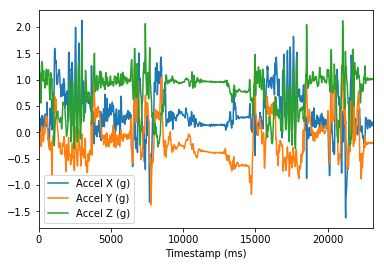

In [334]:
#simulating additive or multiplicative noise
loc = 'dorsal_hand_' + side
sensor = 'accel'

rawdata=act_dict[task][1][loc][sensor]
rawdata.index = rawdata.index-rawdata.index.min()
rawdata.plot()

# plt.ylim([-1,2])

In [330]:
rawdata

,Accel X (g),Accel Y (g),Accel Z (g)
Timestamp (ms),,,
0,0.508003,-0.260441,0.946487
16,0.648753,-0.294621,0.884474
32,0.582956,-0.415961,0.950759
48,0.490181,-0.504463,1.008011
64,0.404608,-0.501900,1.042802
80,0.356634,-0.495796,1.031571
96,0.307805,-0.493965,0.956741
112,0.297673,-0.526192,0.893263
128,0.368475,-0.486519,0.832471


Clips sanity checks

In [100]:
# # loc = 'dorsal_hand_left'
# loc = 'flexor_digitorum_left'
# # loc1 = 'dorsal_hand_left'
# # loc2 = 'anterior_thigh_left'
# locs2 = 'medial_chest'
# clip_data1 = gen_clips(act_dict,task,loc1,clipsize=5000,verbose=True,len_tol=0.9)
# clip_data2 = gen_clips(act_dict,task,loc2,clipsize=5000,verbose=True,len_tol=0.9)

In [101]:

# print(act_dict[task][0][loc1]['accel'].index[-1])
# print(act_dict[task][0][loc2]['accel'].index[-1])
# for v in range(len(clip_data1)):
#     print(len(clip_data1[v]['accel']['data']),len(clip_data2[v]['accel']['data']))
# print(clip_data1[0]['accel']['clip_len'])
# print(clip_data2[0]['accel']['clip_len'])

In [53]:
# #extract both sides scores for corresponding task and subject
# subj_score = mot_scores.loc[mot_scores['Subject']==subj,['Subject','Visit',
#                             task_scores+ ' ' + 'bradykinesia right upper limb',
#                             task_scores+ ' ' + 'tremor right upper limb',
#                             task_scores+ ' ' + 'bradykinesia left upper limb',
#                             task_scores+ ' ' + 'tremor left upper limb',
#                             task_scores+ ' ' + 'overall score']]
# subj_score = subj_score.rename(index=str,
#                                columns={subj_score.columns[2]:'Bradykinesia right',subj_score.columns[3]:'Tremor right', 
#                                        subj_score.columns[4]:'Bradykinesia left',subj_score.columns[5]:'Tremor left',
#                                        subj_score.columns[6]:'overall'})


# Raw sensors data visualization - single subject
### plot all trials data from either one side or both sides

In [54]:
task

'Motor #1: Standing'

In [55]:
#filter data
# loc1 = 'flexor_digitorum_left'
# loc2 = 'flexor_digitorum_right'
loc1 = 'dorsal_hand_left'
loc2 = 'dorsal_hand_right'
# loc1 = 'sacrum'
# loc2 = 'medial_chest'

# HPfilter(act_dict,task=task,loc=loc1)
# HPfilter(act_dict,task=task,loc=loc2)

In [56]:
# BPfilter(act_dict,task=task,loc=loc1)
# BPfilter(act_dict,task=task,loc=loc2)

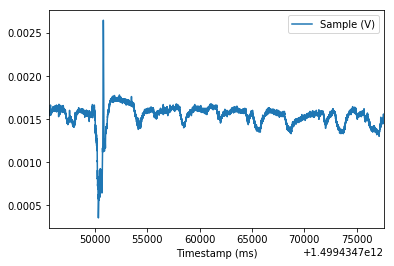

In [57]:
#simulating additive or multiplicative noise
loc = 'flexor_digitorum_left'
sensor = 'elec'

rawdata=act_dict[task][0][loc][sensor]
# rawdata = rawdata.applymap(lambda x: x+(.3/9.81)*np.random.randn(1)[0]) #additive noise
# rawdata = rawdata*1.0*np.random.randn(1)[0]
rawdata.plot()
# plt.ylim([-1,2])

In [58]:
idx = rawdata.index
idx = idx-idx[0]
rawdata.index = idx
rawdata.head()

,Sample (V)
Timestamp (ms),
0,0.001566
1,0.001566
2,0.001560
3,0.001560
4,0.001560


In [59]:
t

NameError: name 't' is not defined

In [ ]:
act_dict[t[0]][t[1]][loc2]['elec']

In [ ]:
filterdata(act_dict,t[0],loc2,t[1],'elec',ftype='bandpass',cutoff_bp=[20,80])

In [ ]:
#plot L and R side
trials = act_dict[task].keys() #all available trials
sns.set_context('paper')
p = product([task],trials)
taskslist = list(p)
for t in taskslist:
    fig=plt.figure()
    ax1 = fig.add_subplot(121)
    plot_data(act_dict,t[0],t[1],loc1,'elec',plt_ax=ax1,add_noise=False,start=5000,end=7000)
    ax1.set_title(tuple([str(subj)])+tuple([str(t[1])])+tuple([loc1]))
#     ax1.set_ylim([0,.00005])
    ax2 = fig.add_subplot(122)
    plot_data(act_dict,t[0],t[1],loc2,'elec',plt_ax=ax2,start=5000,end=7000)
    ax2.set_title(tuple([str(subj)])+tuple([str(t[1])])+tuple([loc2]))
#     ax2.set_ylim([0,.00005])

In [ ]:
#plot L and R side
trials = act_dict[task].keys() #all available trials
sns.set_context('paper')
p = product([task],trials)
taskslist = list(p)
for t in taskslist:
    fig=plt.figure()
    ax1 = fig.add_subplot(121)
    plot_data(act_dict,t[0],t[1],loc1,'accel',plt_ax=ax1,add_noise=False,start=0,end=20000)
    ax1.set_title(tuple([str(subj)])+tuple([str(t[1])])+tuple([loc1]))
    ax1.set_ylim([-2,2])
    ax2 = fig.add_subplot(122)
    plot_data(act_dict,t[0],t[1],loc2,'accel',plt_ax=ax2,start=0,end=20000)
    ax2.set_title(tuple([str(subj)])+tuple([str(t[1])])+tuple([loc2]))
    ax2.set_ylim([-2,2])

In [ ]:
#plot L and R side
trials = act_dict[task].keys() #all available trials
sns.set_context('paper')
p = product([task],trials)
taskslist = list(p)
for t in taskslist:
    fig=plt.figure()
    ax1 = fig.add_subplot(121)
    plot_data(act_dict,t[0],t[1],loc1,'elec',plt_ax=ax1,add_noise=False,start=5000,end=7000)
    ax1.set_title(tuple([str(subj)])+tuple([str(t[1])])+tuple([loc1]))
#     ax1.set_ylim([0,.00005])
    ax2 = fig.add_subplot(122)
    plot_data(act_dict,t[0],t[1],loc2,'elec',plt_ax=ax2,start=5000,end=7000)
    ax2.set_title(tuple([str(subj)])+tuple([str(t[1])])+tuple([loc2]))
#     ax2.set_ylim([0,.00005])

In [ ]:
#plot L and R side
trials = act_dict[task].keys() #all available trials
sns.set_context('paper')
p = product([task],trials)
taskslist = list(p)
for t in taskslist:
    fig=plt.figure()
    ax1 = fig.add_subplot(121)
    plot_data(act_dict,t[0],t[1],loc1,'accel',plt_ax=ax1,add_noise=False,start=0,end=20000)
    ax1.set_title(tuple([str(subj)])+tuple([str(t[1])])+tuple([loc1]))
    ax1.set_ylim([-2,2])
    ax2 = fig.add_subplot(122)
    plot_data(act_dict,t[0],t[1],loc2,'accel',plt_ax=ax2,start=0,end=20000)
    ax2.set_title(tuple([str(subj)])+tuple([str(t[1])])+tuple([loc2]))
    ax2.set_ylim([-2,2])

In [ ]:
#plot L and R side
trials = act_dict[task].keys() #all available trials
sns.set_context('paper')
p = product([task],trials)
taskslist = list(p)
for t in taskslist:
    fig=plt.figure()
    ax1 = fig.add_subplot(121)
    plot_data(act_dict,t[0],t[1],loc1,'elec',plt_ax=ax1,add_noise=False,start=7000,end=9000)
    ax1.set_title(tuple([str(subj)])+tuple([str(t[1])])+tuple([loc1]))
#     ax1.set_ylim([0,.0001])
    ax2 = fig.add_subplot(122)
    plot_data(act_dict,t[0],t[1],loc2,'elec',plt_ax=ax2,start=7000,end=9000)
    ax2.set_title(tuple([str(subj)])+tuple([str(t[1])])+tuple([loc2]))
#     ax2.set_ylim([0,.0001])

In [ ]:
#plot one side only
sns.set_context('paper')
p = product([task],trials)
taskslist = list(p)
for t in taskslist:
    plot_data(act_dict,t[0],t[1],loc,'accel')
    plt.title(tuple([str(subj)])+t+tuple([loc]))

# Plot raw data from all subjects for a given task and trial

In [ ]:
#choose task, trials(visits) and sensor location
loc1 = 'dorsal_hand_left'
loc2 = 'dorsal_hand_right'
# loc1 = 'flexor_digitorum_left'
# loc2 = 'flexor_digitorum_right'
trial = 5

In [ ]:
#list subjects in db
d = os.listdir(path)
all_f = [filename[:4] for filename in d if filename.startswith('1')]
print(np.sort(all_f))

In [ ]:
#load Pickle file dict
for subj in all_f:
    subj_filename = str(subj) + 'dict.pkl'
    f = open(os.path.join(path, subj_filename), 'rb')
    act_dict = pickle.load(f)
    f.close()
    #filter data
    HPfilter(act_dict,task=task,loc=loc1)
    HPfilter(act_dict,task=task,loc=loc2)
    BPfilter(act_dict,task=task,loc=loc1)
    BPfilter(act_dict,task=task,loc=loc2)
    
    fig=plt.figure()
    ax1 = fig.add_subplot(121)
    plot_data(act_dict,task,trial,loc1,'accel',plt_ax=ax1)
    ax1.set_title(tuple([str(subj)])+tuple([str(trial)])+tuple([loc1]))
    ax1.set_ylim([-1,1])
    ax2 = fig.add_subplot(122)
    plot_data(act_dict,task,trial,loc2,'accel',plt_ax=ax2)
    ax2.set_title(tuple([str(subj)])+tuple([str(trial)])+tuple([loc2]))
    ax2.set_ylim([-1,1])

# List of activities / sensor locations

In [ ]:
sorted(list(act_dict.keys()))